# Dark Matter Fraction 

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import glob
from scipy import stats


#################
# Plot parameters
params = {
    "font.size": 20,
    "font.family": "Arial Black",
    "text.usetex": True,
    "mathtext.fontset": "custom",
    "figure.figsize": (4, 3),
    "figure.subplot.left": 0.15,
    "figure.subplot.right": 0.95,
    "figure.subplot.bottom": 0.16,
    "figure.subplot.top": 0.95,
    "figure.subplot.wspace": 0.3,
    "figure.subplot.hspace": 0.3,
    "lines.markersize": 2,
    "lines.linewidth": 1.5,
}
plt.rcParams.update(params)
G = 6.67e-11
K = 1.65**2
kpc = 3.085e16*1e3
##################
# Halo Class

class classhalo:
    def __init__(self, file_path, type = 'all' ):
        self.file_path = file_path
        self.get_group_attributes(type)

    def get_group_attributes(self, type):
        with h5py.File(self.file_path, "r") as file:
            halo_data_group = file["Halo_data"]
            profile_data_group = file["Profile_data"]
            
            self.kappa = halo_data_group["kappa"][:]
            if type == 'disk':
                select = np.where(halo_data_group["kappa"][:] >= 0.3)[0]
            if type == 'elliptical':
                select = np.where(halo_data_group["kappa"][:] < 0.3)[0]
            if type == 'all':
                select = np.where(halo_data_group["kappa"][:] > 0)[0]
            

            # Halo_data attributes
            self.AxisRadius = halo_data_group["AxisRadius"][:]
            self.CrossSection = halo_data_group["CrossSection"][:, select]
            self.DMMajorAxis_a = halo_data_group["DMMajorAxis_a"][:, select]
            self.DMMinorAxis_b = halo_data_group["DMMinorAxis_b"][:, select]
            self.DMMinorAxis_c = halo_data_group["DMMinorAxis_c"][:, select]
            self.DMNparticlesWithinAxisRadius = halo_data_group["DMNparticlesWithinAxisRadius"][:, select]
            self.DynamicalRelaxation = halo_data_group["DynamicalRelaxation"][select]
            self.GalaxyHalfLightRadius = halo_data_group["GalaxyHalfLightRadius"][select]
            self.GalaxyHalfMassRadius = halo_data_group["GalaxyHalfMassRadius"][select]
            self.GalaxyLuminosity = halo_data_group["GalaxyLuminosity"][select]
            self.GalaxyProjectedHalfLightRadius = halo_data_group["GalaxyProjectedHalfLightRadius"][select]
            self.GalaxyProjectedHalfMassRadius = halo_data_group["GalaxyProjectedHalfMassRadius"][select]
            self.ID = halo_data_group["ID"][select]
            self.M200c = halo_data_group["M200c"][select]
            self.Metallicity = halo_data_group["Metallicity"][select]
            self.Mgas = halo_data_group["Mgas"][select]
            self.Mstar = halo_data_group["Mstar"][select]
            self.R200c = halo_data_group["R200c"][select]
            self.SFR = halo_data_group["SFR"][select]
            self.SpecificAngularMomentum = halo_data_group["SpecificAngularMomentum"][select,:]
            self.StructureType = halo_data_group["StructureType"][select]
            self.Vmax = halo_data_group["Vmax"][select]
            self.c200c = halo_data_group["c200c"][select]

            sarg =0

            # Profile_data attributes
            self.Circular_Velocity = profile_data_group["Circular_Velocity"][:, select]
            self.Dark_matter_Circular_Velocity = profile_data_group["Dark_matter_Circular_Velocity"][:, select]
            self.Dark_matter_Density_profile = profile_data_group["Dark_matter_Density_profile"][sarg:,select]
            self.Dark_matter_Sigma_profile = profile_data_group["Dark_matter_Sigma_profile"][sarg:,select]
            self.Dark_matter_Velocity_dispersion = profile_data_group["Dark_matter_Velocity_dispersion"][sarg:,select]
            self.Density_profile = profile_data_group["Density_profile"][sarg:,select]
            self.Density_radial_bins = profile_data_group["Density_radial_bins"][sarg:]
            self.Gas_Circular_Velocity = profile_data_group["Gas_Circular_Velocity"][:,select]
            self.Gas_Density_profile = profile_data_group["Gas_Density_profile"][sarg:,select]
            self.Gas_Velocity_dispersion = profile_data_group["Gas_Velocity_dispersion"][sarg:,select]
            self.Stars_Circular_Velocity = profile_data_group["Stars_Circular_Velocity"][:,select]
            self.Stars_Density_profile = profile_data_group["Stars_Density_profile"][sarg:,select]
            self.Stars_Velocity_dispersion = profile_data_group["Stars_Velocity_dispersion"][sarg:,select]
            self.Velocity_radial_bins = profile_data_group["Velocity_radial_bins"][:]




            self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2


       
        
file_paths = ['Halo_data_L025N376WeakStellarFBSigmaVelDep60Anisotropic.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep30Anisotropic.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaConstant00.hdf5',
              'Halo_data_L025N376ReferenceSigmaConstant00.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep30Anisotropic.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep60Anisotropic.hdf5']

file_names = ['WSFB60', 'WSFB30', 'WSFBconst', 'Ref60', 'Ref30', 'Refconst']


In [3]:
### Useful function to plot median relation with error bar

def plot_median_relation(ax, bins, x, y, errorbars=True, color='grey',label='CDM'):
    num_bins = len(bins)
    indx = np.digitize(x, bins)
    p_bins_medians = np.array([np.median(x[indx == idx]) for idx in np.arange(num_bins) if len(x[indx==idx])>3])
    r_bins_medians = np.array([np.median(y[indx == idx]) for idx in np.arange(num_bins) if len(x[indx==idx])>3])
    ax.plot(p_bins_medians, r_bins_medians, lw=3, color='white')
    ax.plot(p_bins_medians, r_bins_medians, color=color, lw=2.5, label=label)
    
    if errorbars:
        r_bins_16 = np.array([np.percentile(y[indx == idx], 16) for idx in np.arange(num_bins) if len(x[indx==idx])>3]) # Here we request each bin to contain at least x galaxies
        r_bins_84 = np.array([np.percentile(y[indx == idx], 84) for idx in np.arange(num_bins) if len(x[indx==idx])>3]) 
        ax.plot(p_bins_medians, r_bins_16, '--', color=color)
        ax.plot(p_bins_medians, r_bins_84, '--', color=color)
        ax.fill_between(p_bins_medians, r_bins_16, r_bins_84, color=color, alpha=0.15,)

## Dark Matter Fraction as a function of the Stellar Mass

/var/folders/9d/kpkfshms4z18wjb2nmw1ylx95p_t9v/T/ipykernel_77196/2769655278.py:99: RuntimeWarning: divide by zero encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/var/folders/9d/kpkfshms4z18wjb2nmw1ylx95p_t9v/T/ipykernel_77196/2769655278.py:99: RuntimeWarning: invalid value encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2


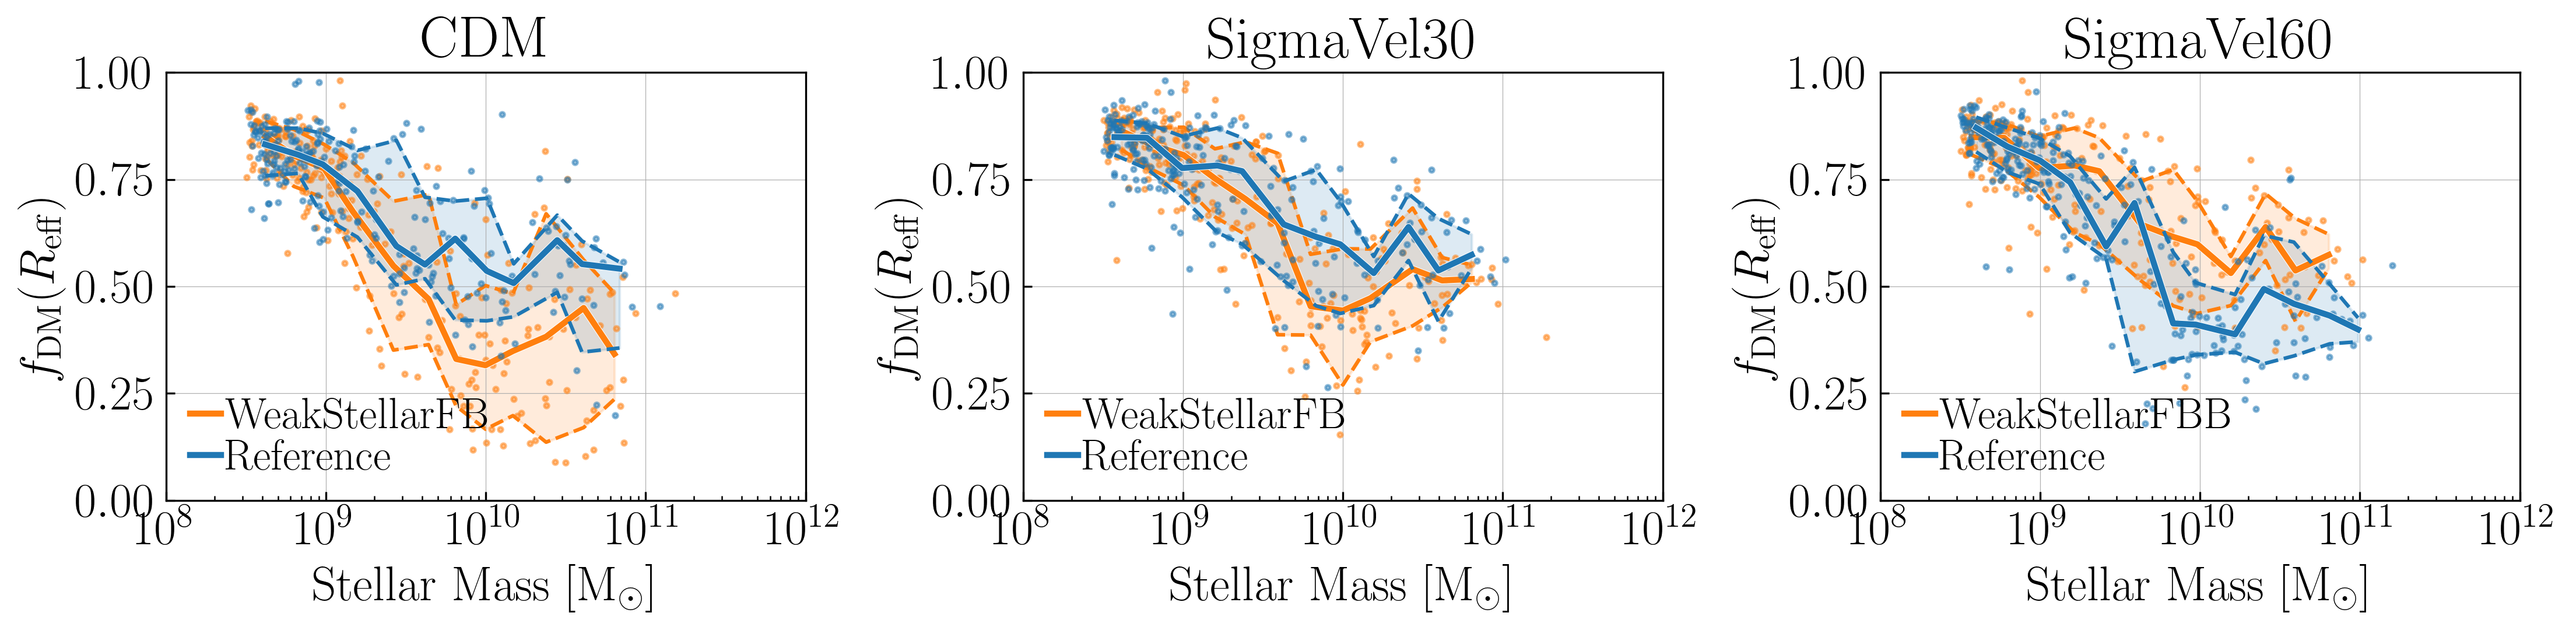

In [4]:
# Define data
file_paths = ['Halo_data_L025N376WeakStellarFBSigmaConstant00.hdf5',
              'Halo_data_L025N376ReferenceSigmaConstant00.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep30Anisotropic.hdf5',
              'Halo_data_L025N376ReferenceSigmaVelDep30Anisotropic.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep30Anisotropic.hdf5', 
              'Halo_data_L025N376WeakStellarFBSigmaVelDep60Anisotropic.hdf5']

file_names = ['WeakStellarFB', 'Reference', 'WeakStellarFB', 'Reference', 'WeakStellarFBB', 'Reference'] # Clearer names
titles = ['CDM', 'SigmaVel30', 'SigmaVel60']  # Adding names following Correa+ (2024)
colors = ['tab:orange', 'tab:blue']

fig, axs = plt.subplots(1, 3, figsize=(15, 4), dpi=300) # Increasing resolution

for j, file_path in enumerate(file_paths):
    ax = axs[j // 2]

    halo = classhalo(file_path, type='all')

    M = 10**halo.Mstar
    fDM = halo.fDM
    f = []
    for k in range(len(fDM[0, :])):
        f = np.append(f, np.interp(halo.GalaxyHalfLightRadius[k], halo.Velocity_radial_bins, fDM[:, k]))

    ax.plot(M, f, 'o',  c=colors[j % 2], alpha=0.5)

    bins = np.arange(halo.Mstar.min(), halo.Mstar.max(), 0.2)
    bins = 10**bins
    plot_median_relation(ax, bins, M, f, errorbars=True, color=colors[j % 2], label=file_names[j])    

    # Here I am adding a suggestion to have an external function that systematically plots the
    # median relation +/- the 16th/84th percentiles

    # bin_means, bin_edges, _ = stats.binned_statistic(M, f, bins=bins, statistic='median')
    # bin_std, _, _ = stats.binned_statistic(M, f, bins=bins, statistic='std')

    #ax.plot(bin_edges[:-1], bin_means + bin_std, '--', color=colors[j % 2], linewidth=0.8, alpha=0.2)
    #ax.plot(bin_edges[:-1], bin_means - bin_std, '--', color=colors[j % 2], linewidth=0.8, alpha=0.2)

    #ax.plot(bin_edges[:-1], bin_means, linestyle='-', label=file_names[j], c=colors[j % 2])
    #ax.fill_between(bin_edges[:-1], bin_means - bin_std, bin_means + bin_std, alpha=0.1, color=colors[j % 2])
    
    ax.legend(loc=[0.01, 0.01], labelspacing=0.05, handlelength=0.7, handletextpad=0.1,
              frameon=False, fontsize=18, ncol=1)

    ax.tick_params(direction='in', axis='both', which='both', pad=4.5) # Minor thing

    ax.set_xlabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')
    ax.set_ylabel(r'$f_{\mathrm{DM}}(R_{\mathrm{eff}})$')
    ax.set_ylim([0, 1])
    ax.set_xlim([10**8, 10**12])
    ax.set_xscale('log')
    ax.grid(linestyle='-', linewidth=0.3)
    ax.set_title(titles[j // 2])

plt.tight_layout()
plt.savefig('fDMvsStelM.pdf')
plt.savefig('fDMvsStelM.png')
plt.show()



## Dark Matter Fraction as a function of the effective radius

/var/folders/9d/kpkfshms4z18wjb2nmw1ylx95p_t9v/T/ipykernel_77196/2769655278.py:99: RuntimeWarning: divide by zero encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/var/folders/9d/kpkfshms4z18wjb2nmw1ylx95p_t9v/T/ipykernel_77196/2769655278.py:99: RuntimeWarning: invalid value encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/Users/cc276407/tools_env/lib/python3.9/site-packages/scipy/stats/_binned_statistic.py:609: RuntimeWarning: invalid value encountered in subtract
  delta = values[vv] - flatsum[binnumbers] / flatcount[binnumbers]
/var/folders/9d/kpkfshms4z18wjb2nmw1ylx95p_t9v/T/ipykernel_77196/2769655278.py:99: RuntimeWarning: divide by zero encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,se

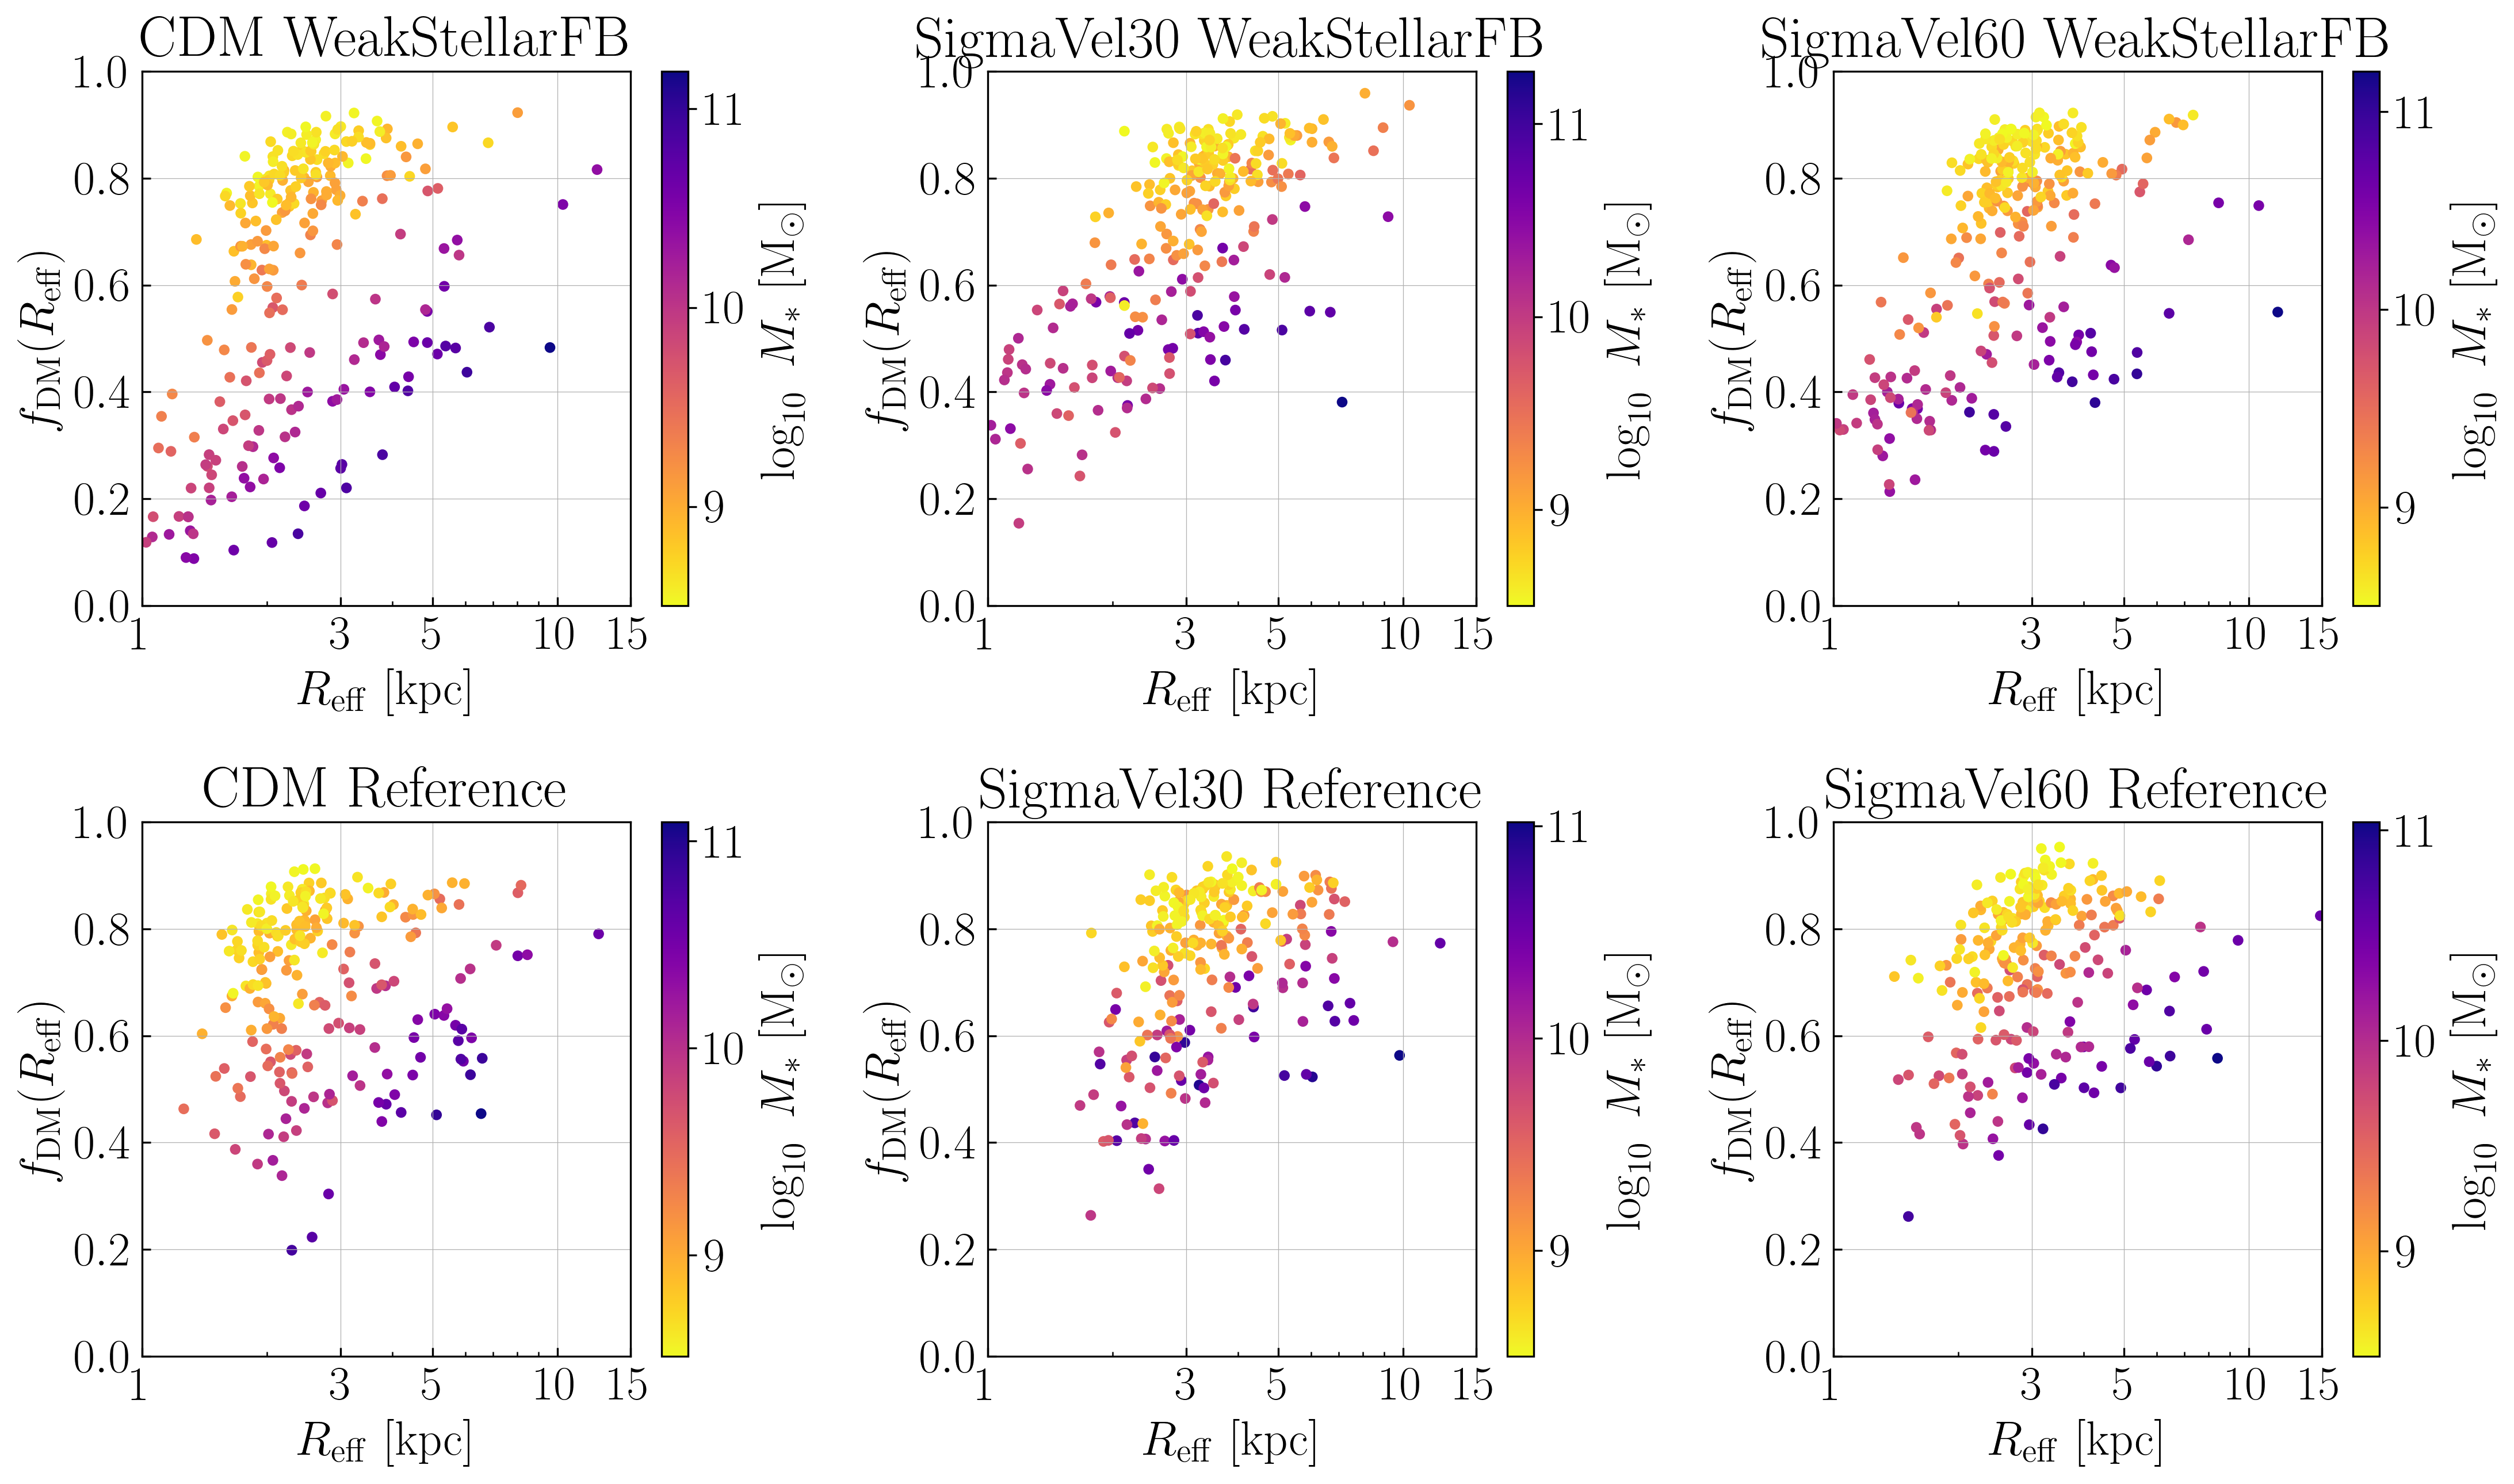

In [5]:
# Define data
file_paths = ['Halo_data_L025N376WeakStellarFBSigmaConstant00.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep30Anisotropic.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep60Anisotropic.hdf5',
              'Halo_data_L025N376ReferenceSigmaConstant00.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep30Anisotropic.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep60Anisotropic.hdf5']

file_names = ['WeakStellarFB', 'WeakStellarFB', 'WeakStellarFB', 'Reference', 'Reference', 'Reference']
titles = ['CDM', 'SigmaVel30', 'SigmaVel60', 'CDM', 'SigmaVel30', 'SigmaVel60'] # Minor changes


fig, axs = plt.subplots(2, 3, figsize=(15, 9), dpi=300) # Increasing resolution (minimum dpi=300 always)

for j, file_path in enumerate(file_paths):
    row = j // 3
    col = j % 3

    ax = axs[row, col]


    ax.set_xlabel(r'$R_{\mathrm{eff}}$ [kpc]')
    ax.set_ylabel(r'$f_{\mathrm{DM}}(R_{\mathrm{eff}})$')
    ax.set_ylim([0, 1])
    ax.set_xlim([1, 15]) # Better in log-scale 
    ax.set_xscale('log')
    ax.grid(linestyle='-', linewidth=0.3)
    ax.set_title(titles[j] + ' ' + file_names[j])

    xticks = np.array([1,3,5,10,15]) # Let's play with the x-ticks
    labels = ["1", "3", "5", "10", "15"]
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)

    halo = classhalo(file_path, type='all')

    Reff = halo.GalaxyHalfLightRadius
    fDM = halo.fDM
    f = []
    for k in range(len(fDM[0, :])):
        f.append(np.interp(halo.GalaxyHalfLightRadius[k], halo.Velocity_radial_bins, fDM[:, k]))

    sc = ax.scatter(Reff, f, c=halo.Mstar, s=12, cmap = 'plasma_r') # Making points bigger

    if j % 1 == 0:
        plt.colorbar(sc, ax=ax, label = r'$\log_{10}~M_{*}$ [$\mathrm{M}_{\odot}]$') # Here are plotting the log10 of stellar mass, then we make it clear in the colorbar label

    ax.tick_params(direction='in', axis='both', which='both', pad=4.5) # Minor thing

    bins = np.arange(halo.GalaxyHalfLightRadius.min(), halo.GalaxyHalfLightRadius.max(), 2)
    
    bin_means, bin_edges, _ = stats.binned_statistic(Reff, f, bins=bins, statistic='median')
    bin_std, _, _ = stats.binned_statistic(Reff, f, bins=bins, statistic='std')

plt.tight_layout()
plt.savefig('fDMvsR.pdf')
plt.savefig('fDMvsR.png')
plt.show()



## Dark Matter Fraction for ellipticals VS disky ones

/var/folders/9d/kpkfshms4z18wjb2nmw1ylx95p_t9v/T/ipykernel_77196/2769655278.py:99: RuntimeWarning: divide by zero encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/var/folders/9d/kpkfshms4z18wjb2nmw1ylx95p_t9v/T/ipykernel_77196/2769655278.py:99: RuntimeWarning: invalid value encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/var/folders/9d/kpkfshms4z18wjb2nmw1ylx95p_t9v/T/ipykernel_77196/2769655278.py:99: RuntimeWarning: invalid value encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/var/folders/9d/kpkfshms4z18wjb2nmw1ylx95p_t9v/T/ipykernel_77196/2769655278.py:99: RuntimeWarning: divide by zero encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,

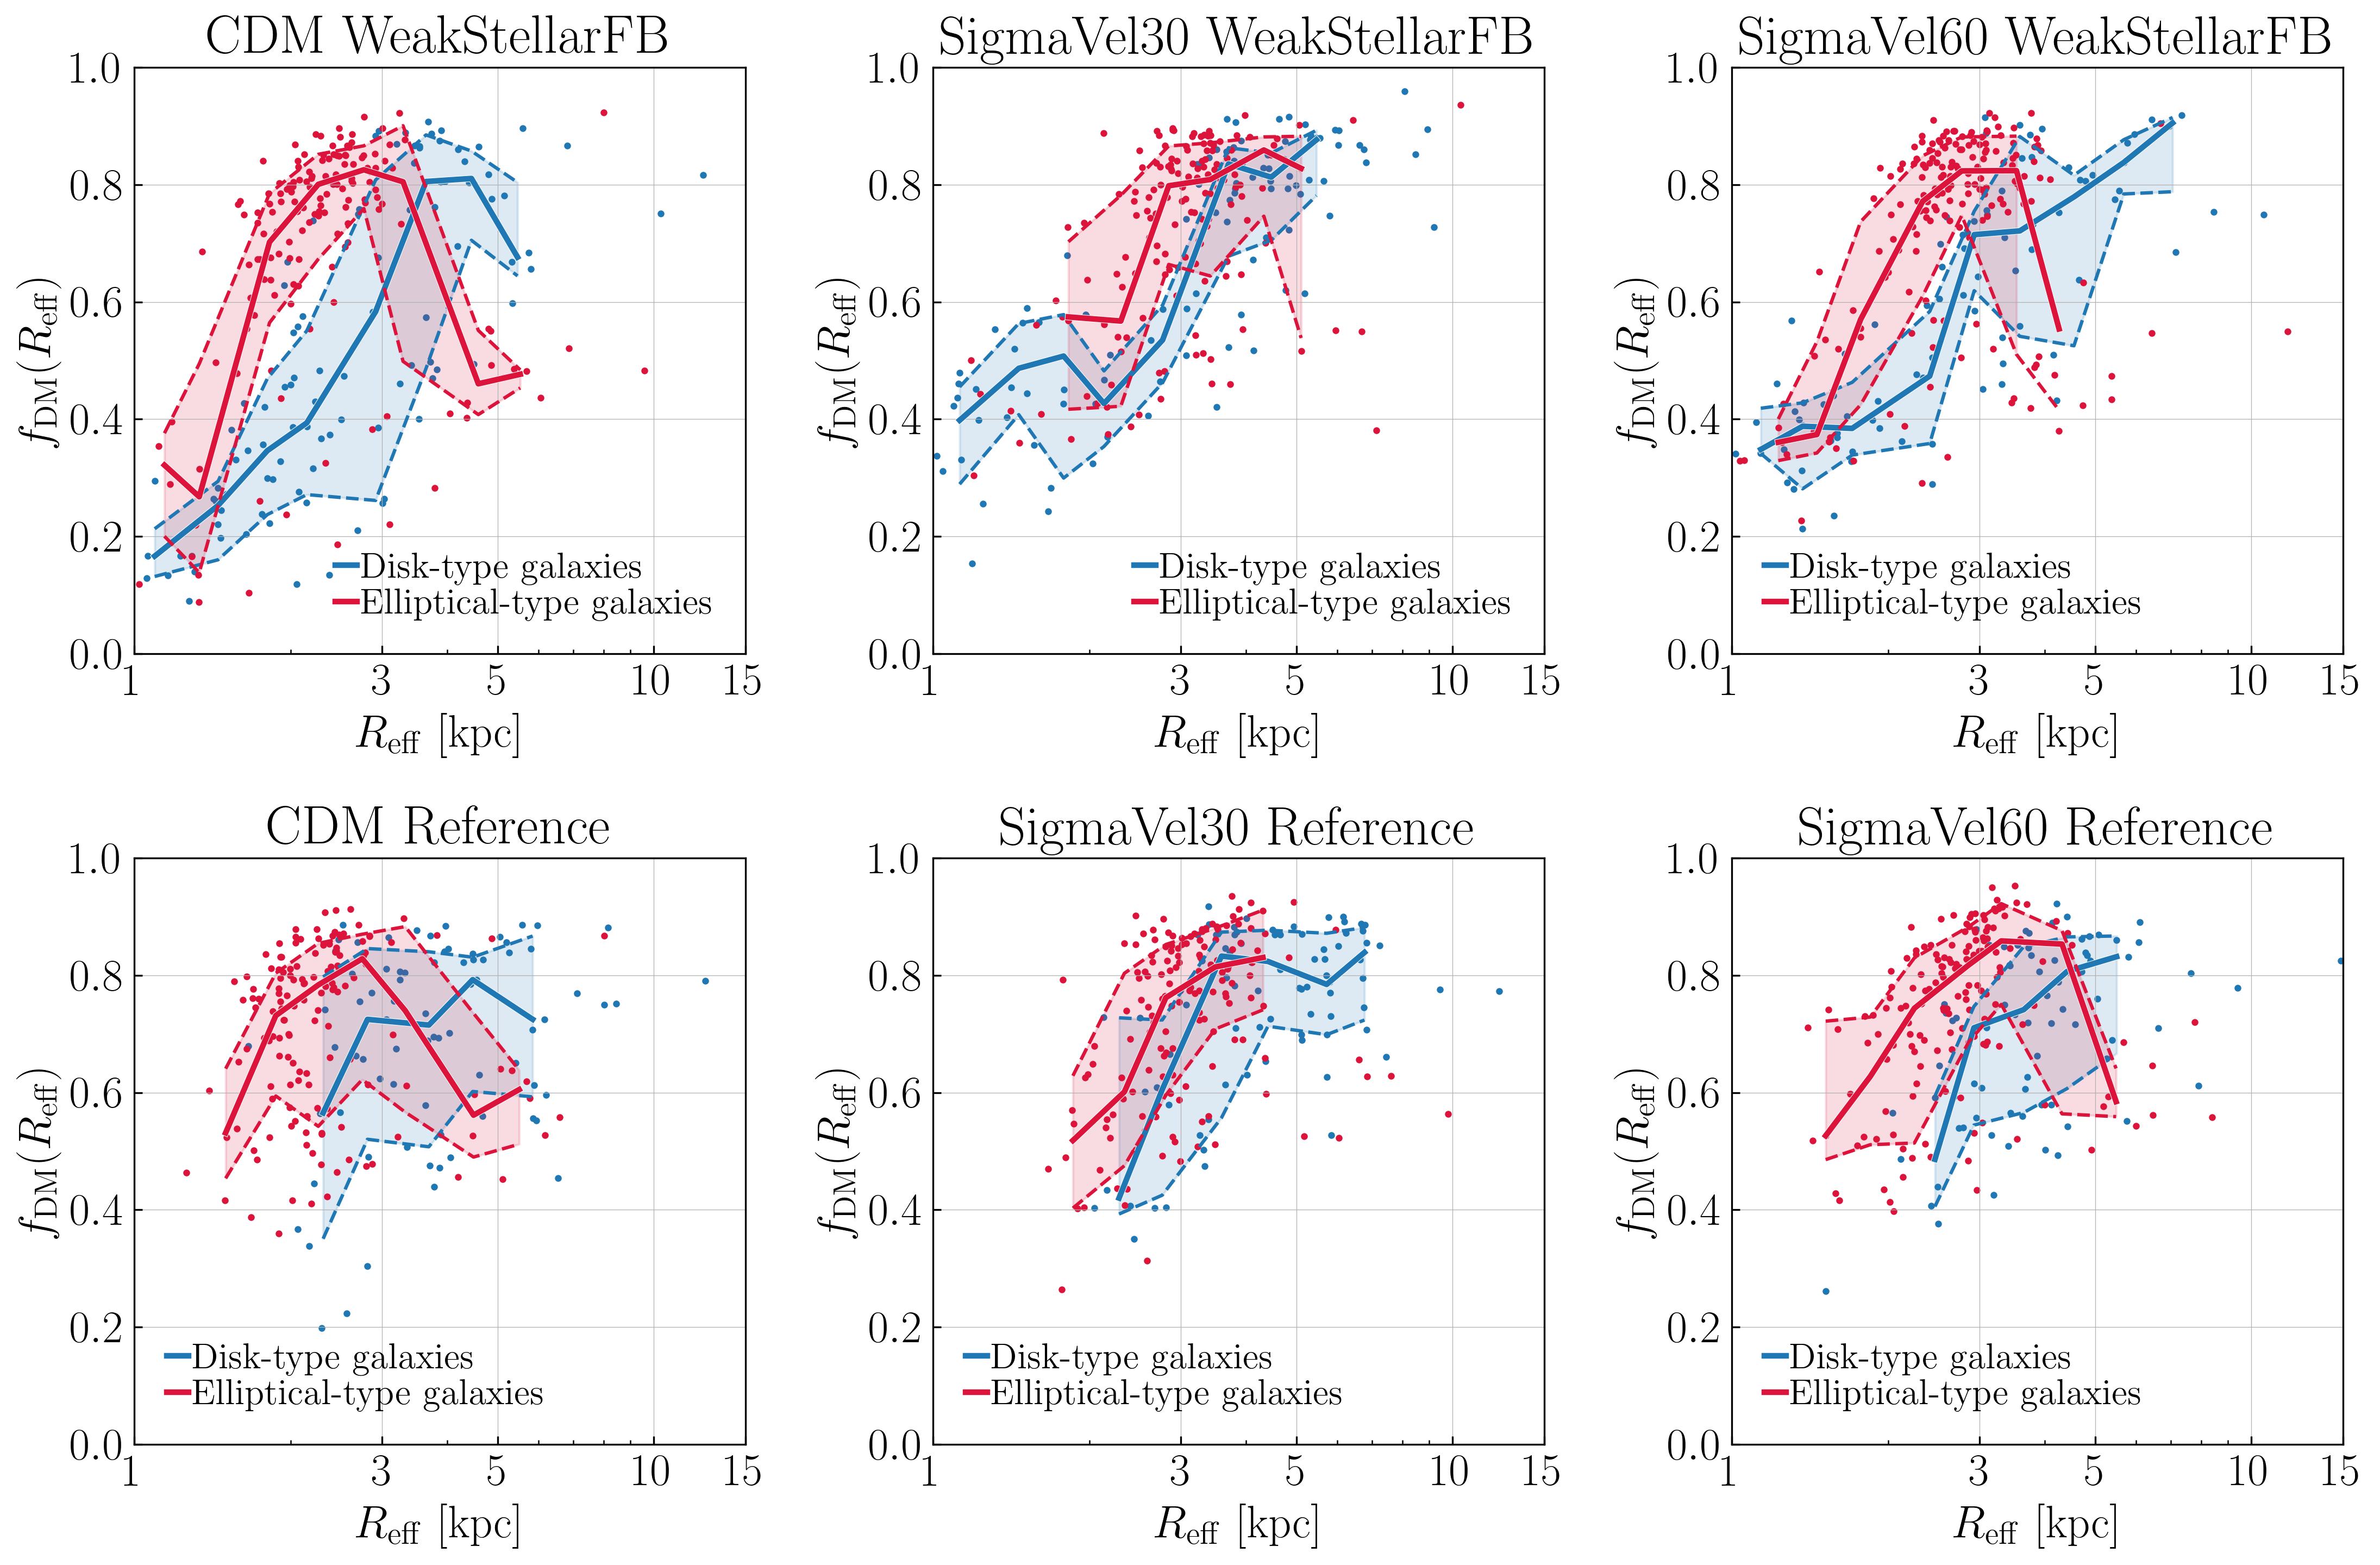

In [6]:
# Define data
maxval = 1e12
minval = 1e8
nb = 0.2


file_paths = ['Halo_data_L025N376WeakStellarFBSigmaConstant00.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep30Anisotropic.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep60Anisotropic.hdf5',
              'Halo_data_L025N376ReferenceSigmaConstant00.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep30Anisotropic.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep60Anisotropic.hdf5']

file_names = ['WeakStellarFB', 'WeakStellarFB', 'WeakStellarFB', 'Reference', 'Reference', 'Reference']
titles = ['CDM', 'SigmaVel30', 'SigmaVel60', 'CDM', 'SigmaVel30', 'SigmaVel60']
#colors = [(174/255, 204/255, 255/255), (1, 63/255, 63/255)]
colors = ['tab:blue','crimson']

# Create figure with 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10), dpi=300)

for j, file_path in enumerate(file_paths):
    row = j // 3
    col = j % 3

    ax = axs[row, col]


    ax.set_xlabel(r'$R_{\mathrm{eff}}$ [kpc]')
    ax.set_ylabel(r'$f_{\mathrm{DM}}(R_{\mathrm{eff}})$')
    ax.set_ylim([0, 1])
    ax.set_xlim([1, 8]) # Better in log-scale 
    ax.set_xscale('log')

    xticks = np.array([1,3,5,10,15]) # Let's play with the x-ticks
    labels = ["1", "3", "5", "10", "15"]
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    
    ax.grid(linestyle='-', linewidth=0.3)
    ax.set_title(titles[j] + ' ' + file_names[j])

    # Plot data for disk
    halo_disk = classhalo(file_path, type='disk')
    i = np.where((10**halo_disk.Mstar<maxval) & (10**halo_disk.Mstar>minval))[0]
    Reff_disk = halo_disk.GalaxyHalfLightRadius[i]
    fDM_disk = halo_disk.fDM[:,i]
    f_disk = [np.interp(halo_disk.GalaxyHalfLightRadius[k], halo_disk.Velocity_radial_bins, fDM_disk[:, k]) for k in range(len(fDM_disk[0, :]))]
    f_disk = np.array(f_disk)

    ax.scatter(Reff_disk, f_disk, c=colors[0])  

    bins = np.arange(np.log10(1), np.log10(8), 0.1) # Let's use same binning throughout
    bins = 10**bins
    plot_median_relation(ax, bins, Reff_disk, f_disk, errorbars=True, color=colors[0], label='Disk-type galaxies')   
    
    # bins_disk = np.arange(halo_disk.GalaxyHalfLightRadius.min(), halo_disk.GalaxyHalfLightRadius.max(), nb)
    # bin_means_disk, bin_edges_disk, _ = stats.binned_statistic(Reff_disk, f_disk, bins=bins_disk, statistic='median')
    # bin_std_disk, _, _ = stats.binned_statistic(Reff_disk, f_disk, bins=bins_disk, statistic='std')

    # ax.plot(bin_edges_disk[:-1], bin_means_disk + bin_std_disk, '--', color=colors[0], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_disk[:-1], bin_means_disk - bin_std_disk, '--', color=colors[0], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_disk[:-1], bin_means_disk, linestyle='-', color=colors[0], label='disk')
    # ax.fill_between(bin_edges_disk[:-1], bin_means_disk - bin_std_disk, bin_means_disk + bin_std_disk, alpha=0.1, color=colors[0])

    # Plot data for elliptical
    halo_elliptical = classhalo(file_path, type='elliptical')
    i = np.where((10**halo_elliptical.Mstar<maxval) & (10**halo_elliptical.Mstar>minval))[0]
    Reff_elliptical = halo_elliptical.GalaxyHalfLightRadius[i]
    fDM_elliptical = halo_elliptical.fDM[:,i]
    f_elliptical = [np.interp(halo_elliptical.GalaxyHalfLightRadius[k], halo_elliptical.Velocity_radial_bins, fDM_elliptical[:, k]) for k in range(len(fDM_elliptical[0, :]))]

    ax.scatter(Reff_elliptical, f_elliptical, c=colors[1])
    f_elliptical = np.array(f_elliptical)
    plot_median_relation(ax, bins, Reff_elliptical, f_elliptical, errorbars=True, color=colors[1], label='Elliptical-type galaxies')   
    
    # bins_elliptical = np.arange(halo_elliptical.GalaxyHalfLightRadius.min(), halo_elliptical.GalaxyHalfLightRadius.max(), nb)
    # bin_means_elliptical, bin_edges_elliptical, _ = stats.binned_statistic(Reff_elliptical, f_elliptical, bins=bins_elliptical, statistic='median')
    # bin_std_elliptical, _, _ = stats.binned_statistic(Reff_elliptical, f_elliptical, bins=bins_elliptical, statistic='std')

    # ax.plot(bin_edges_elliptical[:-1], bin_means_elliptical + bin_std_elliptical, '--', color=colors[1], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_elliptical[:-1], bin_means_elliptical - bin_std_elliptical, '--', color=colors[1], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_elliptical[:-1], bin_means_elliptical, linestyle='-', color=colors[1], label='elliptical')
    # ax.fill_between(bin_edges_elliptical[:-1], bin_means_elliptical - bin_std_elliptical, bin_means_elliptical + bin_std_elliptical, alpha=0.1, color=colors[1])

    ax.legend(labelspacing=0.1,handlelength=0.6,handletextpad=0.1,frameon=False,fontsize=16,columnspacing=0.5,ncol=1) # We can play with legend..
    ax.tick_params(direction='in', axis='both', which='both', pad=4.5) # Minor thing
    
plt.tight_layout()
plt.savefig('fDMvsR_type.pdf')
plt.savefig('fDMvsR_type.png')

plt.show()


/var/folders/9d/kpkfshms4z18wjb2nmw1ylx95p_t9v/T/ipykernel_77196/3255278254.py:44: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(M_disk, f_disk, c=colors[0])
/var/folders/9d/kpkfshms4z18wjb2nmw1ylx95p_t9v/T/ipykernel_77196/2769655278.py:99: RuntimeWarning: divide by zero encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/var/folders/9d/kpkfshms4z18wjb2nmw1ylx95p_t9v/T/ipykernel_77196/2769655278.py:99: RuntimeWarning: invalid value encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/var/folders/9

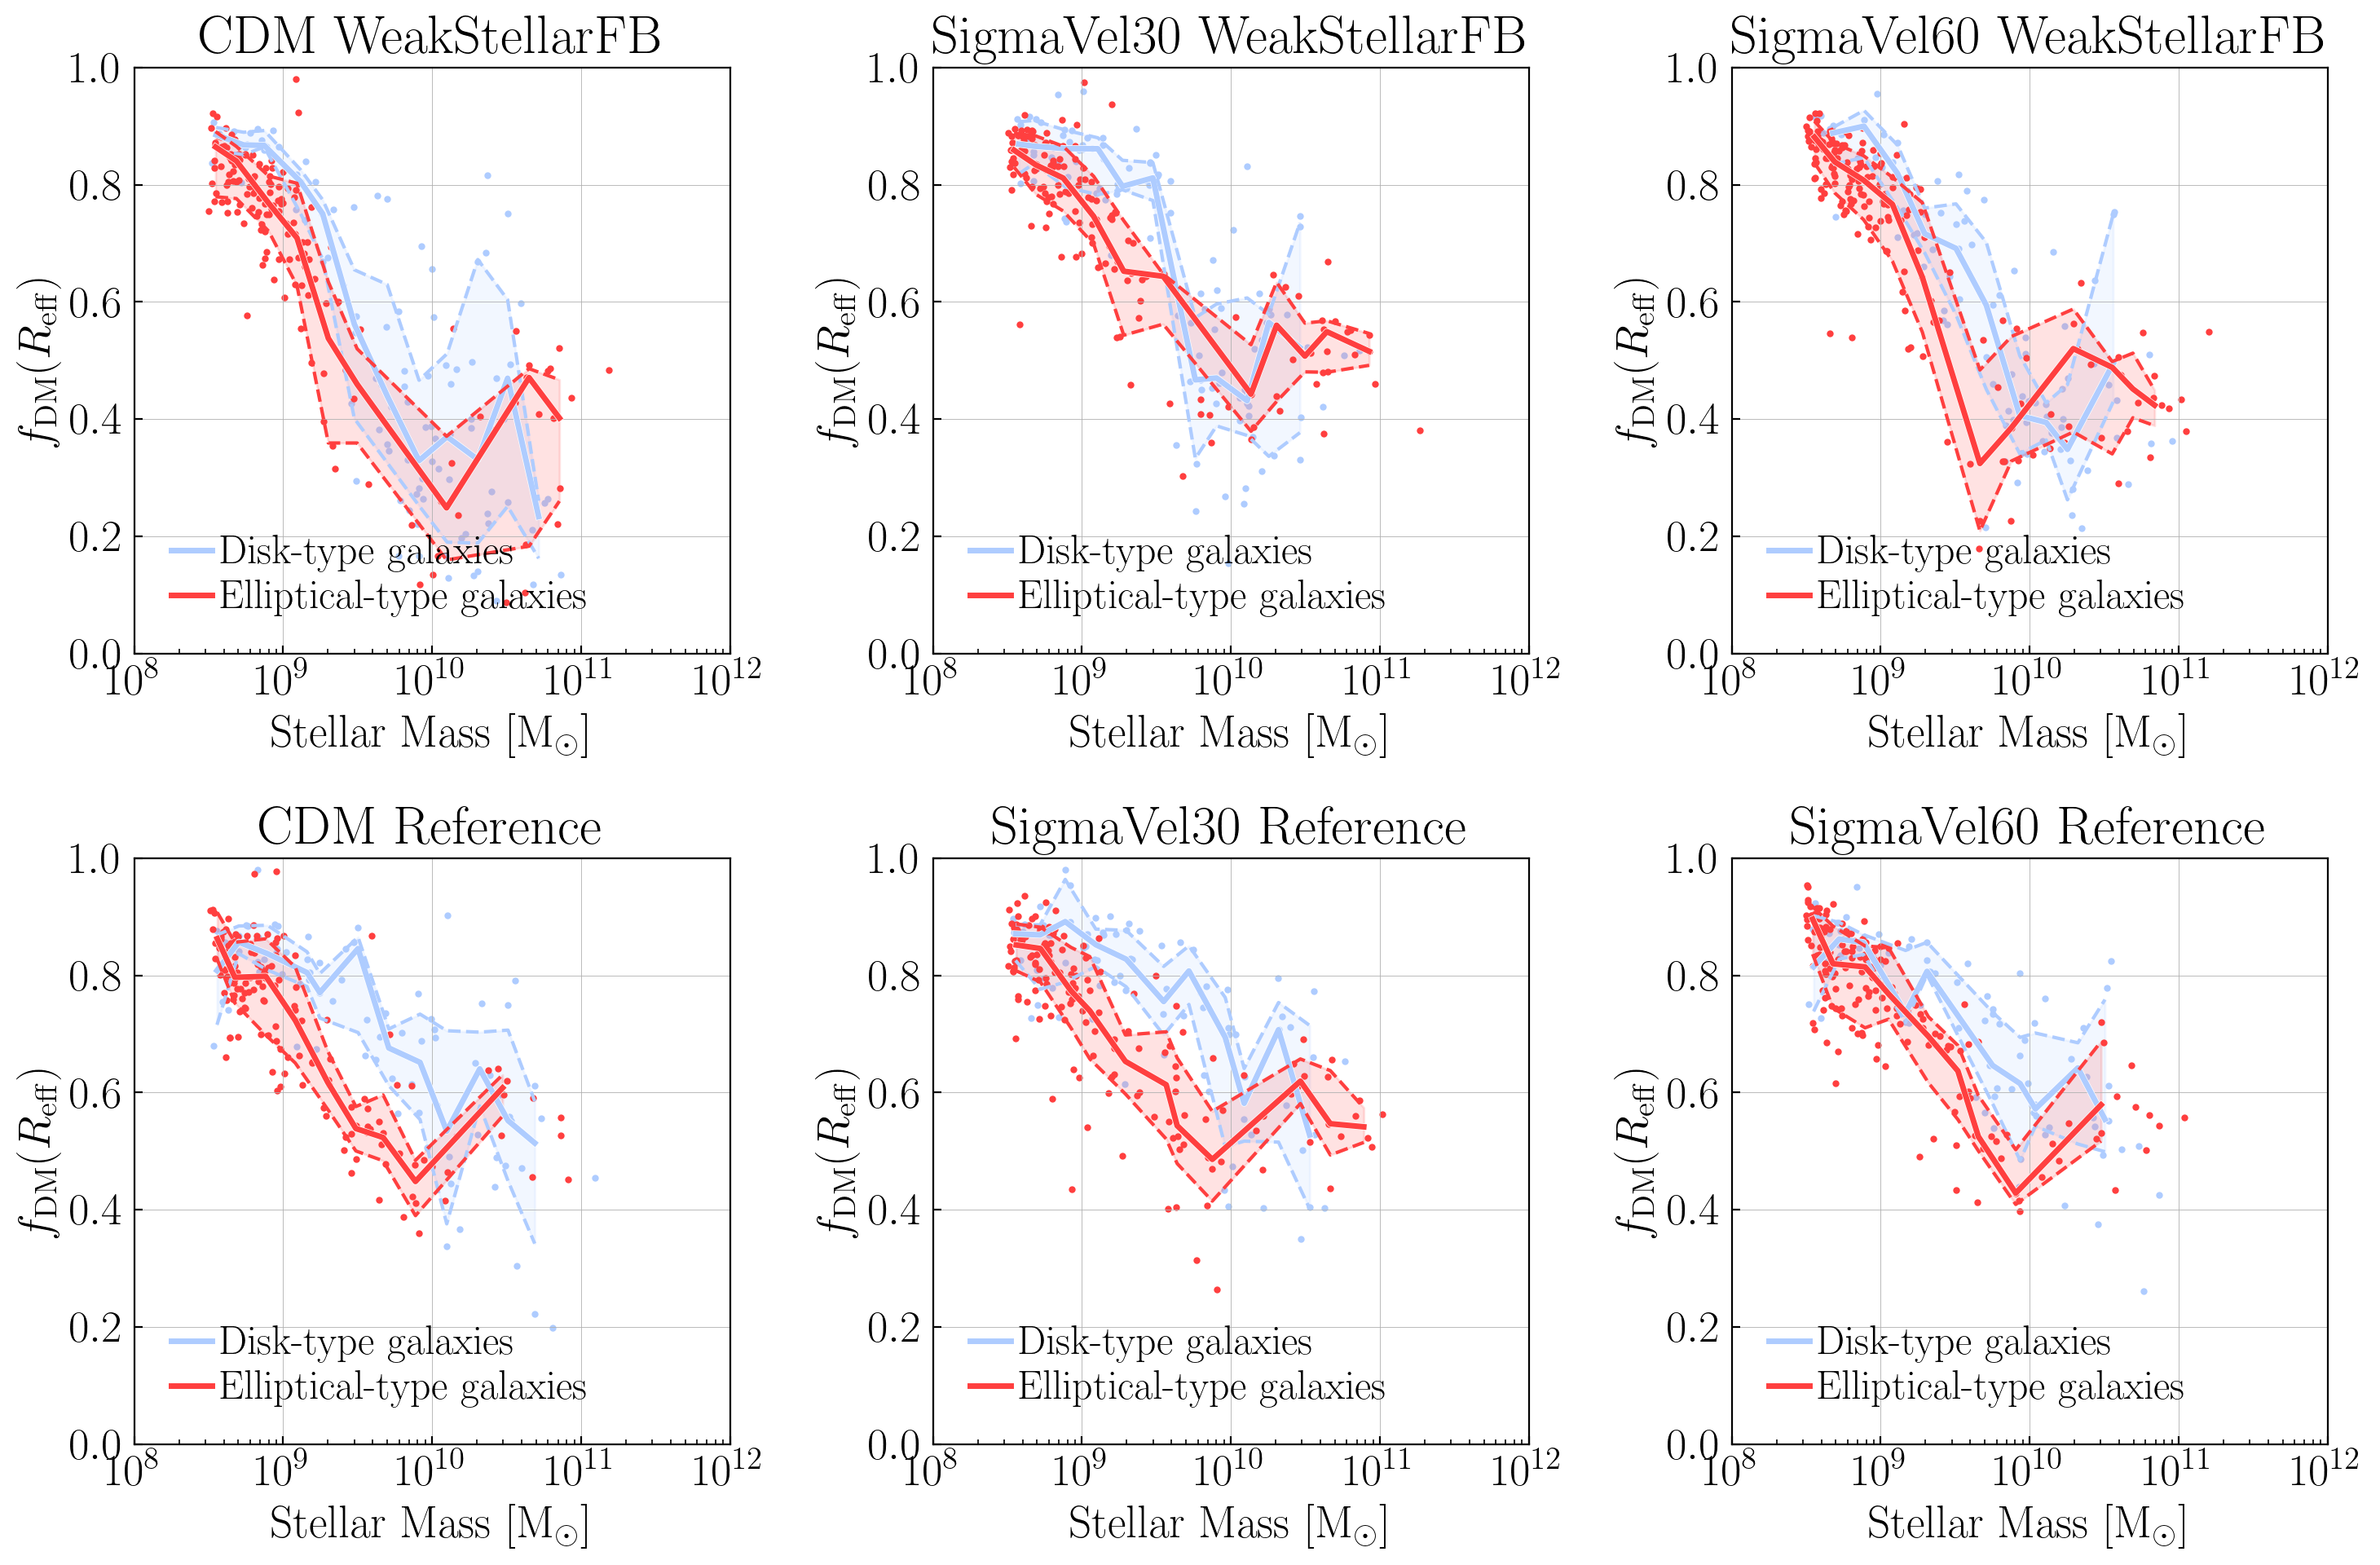

In [7]:
## Define data
maxval = 1e12
minval = 1e8
nb = 0.2


file_paths = ['Halo_data_L025N376WeakStellarFBSigmaConstant00.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep30Anisotropic.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep60Anisotropic.hdf5',
              'Halo_data_L025N376ReferenceSigmaConstant00.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep30Anisotropic.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep60Anisotropic.hdf5']

file_names = ['WeakStellarFB', 'WeakStellarFB', 'WeakStellarFB', 'Reference', 'Reference', 'Reference']
titles = ['CDM', 'SigmaVel30', 'SigmaVel60', 'CDM', 'SigmaVel30', 'SigmaVel60']
colors = [(174/255, 204/255, 255/255), (1, 63/255, 63/255)] 

# Create figure with 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10), dpi=200)

for j, file_path in enumerate(file_paths):
    row = j // 3
    col = j % 3

    ax = axs[row, col]


    ax.set_xlabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')
    ax.set_ylabel(r'$f_{\mathrm{DM}}(R_{\mathrm{eff}})$')
    ax.set_ylim([0, 1])
    ax.set_xlim([10**8, 10**12])
    ax.set_xscale('log')
    ax.grid(linestyle='-', linewidth=0.3)
    ax.set_title(titles[j] + ' ' + file_names[j])

    # Plot data for disk
    halo_disk = classhalo(file_path, type='disk')
    i = np.where((10**halo_disk.Mstar<maxval) & (10**halo_disk.Mstar>minval))[0]
    M_disk = 10**halo_disk.Mstar[i]
    fDM_disk = halo_disk.fDM[:,i]
    f_disk = [np.interp(halo_disk.GalaxyHalfLightRadius[k], halo_disk.Velocity_radial_bins, fDM_disk[:, k]) for k in range(len(fDM_disk[0, :]))]
    f_disk = np.array(f_disk)

    ax.scatter(M_disk, f_disk, c=colors[0])  

    bins = np.arange(8, 12, 0.2) # Let's use same binning throughout
    bins = 10**bins
    plot_median_relation(ax, bins, M_disk, f_disk, errorbars=True, color=colors[0], label='Disk-type galaxies')   

    # bins_disk = 10**np.arange(halo_disk.Mstar.min(), halo_disk.Mstar.max(), nb)
    # bin_means_disk, bin_edges_disk, _ = stats.binned_statistic(M_disk, f_disk, bins=bins_disk, statistic='median')
    # bin_std_disk, _, _ = stats.binned_statistic(M_disk, f_disk, bins=bins_disk, statistic='std')

    # ax.plot(bin_edges_disk[:-1], bin_means_disk + bin_std_disk, '--', color=colors[0], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_disk[:-1], bin_means_disk - bin_std_disk, '--', color=colors[0], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_disk[:-1], bin_means_disk, linestyle='-', color=colors[0], label='disk')
    # ax.fill_between(bin_edges_disk[:-1], bin_means_disk - bin_std_disk, bin_means_disk + bin_std_disk, alpha=0.1, color=colors[0])

    # Plot data for elliptical
    halo_elliptical = classhalo(file_path, type='elliptical')
    i = np.where((10**halo_elliptical.Mstar<maxval) & (10**halo_elliptical.Mstar>minval))[0]
    M_elliptical = 10**halo_elliptical.Mstar[i]
    fDM_elliptical = halo_elliptical.fDM[:,i]
    f_elliptical = [np.interp(halo_elliptical.GalaxyHalfLightRadius[k], halo_elliptical.Velocity_radial_bins, fDM_elliptical[:, k]) for k in range(len(fDM_elliptical[0, :]))]
    f_elliptical = np.array(f_elliptical)
    
    ax.scatter(M_elliptical, f_elliptical, c=colors[1]) 
    plot_median_relation(ax, bins, M_elliptical, f_elliptical, errorbars=True, color=colors[1], label='Elliptical-type galaxies')   
    # bins_elliptical = 10**np.arange(halo_elliptical.Mstar.min(), halo_elliptical.Mstar.max(), nb)
    # bin_means_elliptical, bin_edges_elliptical, _ = stats.binned_statistic(M_elliptical, f_elliptical, bins=bins_elliptical, statistic='median')
    # bin_std_elliptical, _, _ = stats.binned_statistic(M_elliptical, f_elliptical, bins=bins_elliptical, statistic='std')

    # ax.plot(bin_edges_elliptical[:-1], bin_means_elliptical + bin_std_elliptical, '--', color=colors[1], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_elliptical[:-1], bin_means_elliptical - bin_std_elliptical, '--', color=colors[1], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_elliptical[:-1], bin_means_elliptical, linestyle='-', color=colors[1], label='elliptical')
    # ax.fill_between(bin_edges_elliptical[:-1], bin_means_elliptical - bin_std_elliptical, bin_means_elliptical + bin_std_elliptical, alpha=0.1, color=colors[1])

    ax.legend(labelspacing=0.2,handlelength=1,handletextpad=0.2,frameon=False,fontsize=18,columnspacing=0.5,ncol=1)
    ax.tick_params(direction='in', axis='both', which='both', pad=4.5) # Minor thing

plt.tight_layout()
plt.savefig('fDMvsM_type.pdf')
plt.savefig('fDMvsM_type.png')

plt.show()
